### Исследование алгоритмов тематического моделирования на примере новостной ленты социальной сети
Предварительная обработка текста, создание тематических моделей и их визуализация. Для начала установим все необходимые библеотеки.
Библеотеки которые нам понадобятся:

In [1]:
import re
import numpy as np
import pandas as pd 
from pprint import pprint

# Gensim - содержит алгоритмы тематического моделирования
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel

# spacy для лемматизации, обработки текста
import spacy

# pyLDAvis - плагин визуализации модели LDA
import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt # matplotlib - библиотека визуализации данных двумерной графикой
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK - содержит алгоритмы лемматизаций и словарь стоп-слов
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')
stop_words.append('источник')

In [3]:
# Импортируем Dataset
df = pd.read_json('vk-news-feed.json')
df.head()

,source_id,date,can_doubt_category,can_set_category,post_type,text,marked_as_ads,attachments,post_source,comments,...,reposts,views,is_favorite,post_id,type,signer_id,copyright,category_action,topic_id,copy_history
0,-141514192,2021-07-11 16:10:31,0.0,0.0,post,Жительница Ижевска незаконно прописала у себя ...,0.0,"[{'type': 'photo', 'photo': {'album_id': -7, '...","{'type': 'api', 'platform': 'android'}","{'count': 0, 'can_post': 1}",...,"{'count': 0, 'user_reposted': 0}",{'count': 898},False,1697460,post,NaN,NaN,NaN,NaN,NaN
1,-41497214,2021-07-11 16:10:00,0.0,0.0,post,,0.0,"[{'type': 'photo', 'photo': {'album_id': -7, '...",{'type': 'vk'},"{'count': 0, 'can_post': 1, 'groups_can_post':...",...,"{'count': 1, 'user_reposted': 0}",{'count': 190},False,117140,post,NaN,NaN,NaN,NaN,NaN
2,-120206352,2021-07-11 16:10:00,0.0,0.0,post,В России создадут реестр бездомных \n \nСоздан...,0.0,"[{'type': 'photo', 'photo': {'album_id': -7, '...","{'type': 'api', 'platform': 'android'}","{'count': 0, 'can_post': 1, 'groups_can_post':...",...,"{'count': 1, 'user_reposted': 0}",{'count': 916},False,974202,post,NaN,NaN,NaN,NaN,NaN
3,-126888952,2021-07-11 15:43:00,0.0,0.0,post,🌟 ПРЯМОЙ ЭФИР 🌟\n\nЗАВТРА - в 19:00 - ЗДЕСЬ в ...,0.0,"[{'type': 'photo', 'photo': {'album_id': -7, '...",{'type': 'vk'},"{'count': 0, 'can_post': 1, 'groups_can_post':...",...,"{'count': 1, 'user_reposted': 0}",{'count': 60},False,4582,post,NaN,NaN,NaN,NaN,NaN
4,-120206352,2021-07-11 15:30:01,0.0,0.0,post,У меня температура 39. Через сколько часов при...,0.0,"[{'type': 'photo', 'photo': {'album_id': -7, '...","{'type': 'api', 'platform': 'android'}","{'count': 9, 'can_post': 1, 'groups_can_post':...",...,"{'count': 6, 'user_reposted': 0}",{'count': 6778},False,974191,post,NaN,NaN,NaN,NaN,NaN


### Предварительная обработка данных

In [4]:
# Convert to list
data = df.text.values.tolist()
pprint(data[7])
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove URL
data = [re.sub('https?:\/\/.*[\r\n]*', '', sent) for sent in data]

# Remove Domain name
data = [re.sub('[\S]+\.(net|news|com|org|info|edu|gov|uk|de|ca|jp|fr|au|us|ru|ch|it|nel|se|no|es|mil)[\S]*\s?','', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[7])

('Спортсменки из Удмуртии взяли серебро в парной гонке на первенстве России по '
 'велоспорту. \n'
 '\n'
 'Первое место взяли спортсменки из Санкт-Петербурга\n'
 '\n'
 'Парная гонка среди девушек 15-16 лет завершилась 9 июля. Она походила в '
 'рамках Первенства России по велоспорту. Об этом сообщила пресс служба '
 'минспорта Удмуртии.\n'
 '\n'
 'Александра Данилова и Виктория Измайлова проехали дистанцию 25 км, они '
 'преодолевали ее в Завьяловском районе. По итогу девушки заняли второе '
 'место.\n'
 '\n'
 'Первыми стали Анастасия Бек и Асия Сагдиева из Санкт-Петербурга , Бронза '
 'досталась Марине Сычевой и Анне Обрезковой из Свердловской области.\n'
 '\n'
 'Участие в гонке приняли 40 спортсменок\n'
 '\n'
 'Источник www.izh.kp.ru')
('Спортсменки из Удмуртии взяли серебро в парной гонке на первенстве России по '
 'велоспорту. Первое место взяли спортсменки из Санкт-Петербурга Парная гонка '
 'среди девушек 15-16 лет завершилась 9 июля. Она походила в рамках Первенства '
 'России п

In [5]:
# Токенизация
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True удаляет пунктуацию

data_words = list(sent_to_words(data))

print(data_words[7])

['спортсменки', 'из', 'удмуртии', 'взяли', 'серебро', 'парнои', 'гонке', 'на', 'первенстве', 'россии', 'по', 'велоспорту', 'первое', 'место', 'взяли', 'спортсменки', 'из', 'санкт', 'петербурга', 'парная', 'гонка', 'среди', 'девушек', 'лет', 'завершилась', 'июля', 'она', 'походила', 'рамках', 'первенства', 'россии', 'по', 'велоспорту', 'об', 'этом', 'сообщила', 'пресс', 'служба', 'минспорта', 'удмуртии', 'александра', 'данилова', 'виктория', 'измаилова', 'проехали', 'дистанцию', 'км', 'они', 'преодолевали', 'ее', 'завьяловском', 'раионе', 'по', 'итогу', 'девушки', 'заняли', 'второе', 'место', 'первыми', 'стали', 'анастасия', 'бек', 'асия', 'сагдиева', 'из', 'санкт', 'петербурга', 'бронза', 'досталась', 'марине', 'сычевои', 'анне', 'обрезковои', 'из', 'свердловскои', 'области', 'участие', 'гонке', 'приняли', 'спортсменок', 'источник']


In [6]:
# Строим модели биграмм и триграмм
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Более быстрый способ превратить предложение в триграмму / биграмму
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Просмотр триграмм / биграмм
print(trigram_mod[bigram_mod[data_words[7]]])

['спортсменки', 'из', 'удмуртии', 'взяли', 'серебро', 'парнои', 'гонке', 'на', 'первенстве', 'россии', 'по', 'велоспорту', 'первое', 'место', 'взяли', 'спортсменки', 'из', 'санкт', 'петербурга', 'парная', 'гонка', 'среди', 'девушек', 'лет', 'завершилась', 'июля', 'она', 'походила', 'рамках', 'первенства', 'россии', 'по', 'велоспорту', 'об_этом', 'сообщила', 'пресс_служба', 'минспорта', 'удмуртии', 'александра', 'данилова', 'виктория', 'измаилова', 'проехали', 'дистанцию', 'км', 'они', 'преодолевали', 'ее', 'завьяловском', 'раионе', 'по', 'итогу', 'девушки', 'заняли', 'второе', 'место', 'первыми', 'стали', 'анастасия', 'бек', 'асия', 'сагдиева', 'из', 'санкт', 'петербурга', 'бронза', 'досталась', 'марине', 'сычевои', 'анне', 'обрезковои', 'из', 'свердловскои', 'области', 'участие', 'гонке', 'приняли', 'спортсменок', 'источник']


In [7]:
# Определяем функции для стоп-слов, биграмм, триграмм и лемматизации
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Удаляем стоп-слова
data_words_nostops = remove_stopwords(data_words)
print(data_words_nostops[7])

# Формируем биграммы
data_words_bigrams = make_bigrams(data_words_nostops)
print(data_words_bigrams[7])

# Загружаем модель русского языка для лемматизации
nlp = spacy.load('ru2_combined_400ks_96', disable=['parser', 'ner'])

# Осуществляем лемматизацию 
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[7])

['спортсменки', 'удмуртии', 'взяли', 'серебро', 'парнои', 'гонке', 'первенстве', 'россии', 'велоспорту', 'первое', 'место', 'взяли', 'спортсменки', 'санкт', 'петербурга', 'парная', 'гонка', 'среди', 'девушек', 'лет', 'завершилась', 'июля', 'походила', 'рамках', 'первенства', 'россии', 'велоспорту', 'сообщила', 'пресс', 'служба', 'минспорта', 'удмуртии', 'александра', 'данилова', 'виктория', 'измаилова', 'проехали', 'дистанцию', 'км', 'преодолевали', 'завьяловском', 'раионе', 'итогу', 'девушки', 'заняли', 'второе', 'место', 'первыми', 'стали', 'анастасия', 'бек', 'асия', 'сагдиева', 'санкт', 'петербурга', 'бронза', 'досталась', 'марине', 'сычевои', 'анне', 'обрезковои', 'свердловскои', 'области', 'участие', 'гонке', 'приняли', 'спортсменок']
['спортсменки', 'удмуртии', 'взяли', 'серебро', 'парнои', 'гонке', 'первенстве', 'россии', 'велоспорту', 'первое', 'место', 'взяли', 'спортсменки', 'санкт', 'петербурга', 'парная', 'гонка', 'среди', 'девушек', 'лет', 'завершилась', 'июля', 'походила

In [9]:
# Создаем словарь
id2word = corpora.Dictionary(data_lemmatized)

# Создаем корпус
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Просмотр
print(corpus[7])

[(4, 1), (19, 2), (26, 1), (35, 2), (81, 1), (253, 1), (397, 1), (398, 1), (399, 1), (400, 1), (401, 1), (402, 1), (403, 2), (404, 2), (405, 1), (406, 3), (407, 1), (408, 1), (409, 2), (410, 1), (411, 1), (412, 1), (413, 1), (414, 1), (415, 1), (416, 1), (417, 1), (418, 1), (419, 1), (420, 1), (421, 2), (422, 1), (423, 1), (424, 2), (425, 2), (426, 1), (427, 1), (428, 1), (429, 1), (430, 1), (431, 1), (432, 2), (433, 1), (434, 1), (435, 1), (436, 3), (437, 1), (438, 1), (439, 2), (440, 1)]


In [10]:
# Удобочитаемый формат корпуса (термин-частота)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:8]]

[[('азербаиджана', 1),
  ('банда', 1),
  ('вина', 1),
  ('виновнои', 1),
  ('год', 3),
  ('гражданин', 1),
  ('гражданство', 1),
  ('группа', 1),
  ('женщина', 1),
  ('жительница', 2),
  ('заниматься', 1),
  ('ижевск', 2),
  ('ижевчанка', 1),
  ('иностранец', 4),
  ('иностранный', 1),
  ('квартира', 3),
  ('колония', 1),
  ('лицо', 1),
  ('март', 1),
  ('место', 1),
  ('москва', 1),
  ('незаконно', 1),
  ('нынешний', 1),
  ('оштрафовать', 1),
  ('постановка', 1),
  ('пребывание', 1),
  ('пресс_служба', 1),
  ('приговорить', 2),
  ('признание', 1),
  ('признать', 1),
  ('проживать', 1),
  ('прокуратура', 2),
  ('прописать', 2),
  ('прописка', 1),
  ('республика', 1),
  ('россия', 1),
  ('рублеи', 1),
  ('сами', 1),
  ('своеи', 2),
  ('сообщать', 1),
  ('статья', 1),
  ('суд', 3),
  ('также', 1),
  ('тысяча', 2),
  ('удмуртскои', 1),
  ('ук', 1),
  ('украина', 1),
  ('уроженец', 1),
  ('установить', 1),
  ('участник', 1),
  ('учёт', 3),
  ('фиктивнои', 1),
  ('фиктивный', 2),
  ('человек

## LDA

In [11]:
# Строим LDA модель
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [12]:
lda_model.print_topics()

[(0,
  '0.035*"цена" + 0.020*"подорожать" + 0.015*"также" + 0.015*"рубль" + 0.010*"средний" + 0.010*"повышение" + 0.010*"наиболее" + 0.010*"дизельный" + 0.010*"бензин" + 0.010*"снизиться"'),
 (1,
  '0.030*"помощь" + 0.023*"температура" + 0.022*"врач" + 0.020*"пациент" + 0.017*"поликлиника" + 0.012*"вызов" + 0.011*"скорый" + 0.011*"скорои" + 0.011*"госпитализация" + 0.009*"симптом"'),
 (2,
  '0.018*"удмуртия" + 0.018*"также" + 0.015*"аэропорт" + 0.012*"получить" + 0.012*"сообщить" + 0.012*"средство" + 0.012*"абрамченко" + 0.012*"жилищный" + 0.012*"финансирование" + 0.012*"пассажир"'),
 (3,
  '0.021*"россия" + 0.017*"доктор" + 0.016*"мясник" + 0.012*"диаграмма" + 0.012*"возраст" + 0.011*"объяснить" + 0.011*"противник" + 0.011*"волна" + 0.011*"специалист" + 0.011*"множество"'),
 (4,
  '0.034*"посёлок" + 0.031*"дорога" + 0.017*"житель" + 0.017*"восточный" + 0.017*"город" + 0.014*"год" + 0.014*"улица" + 0.014*"мера" + 0.014*"заказать" + 0.010*"документ"'),
 (5,
  '0.017*"остановка" + 0.013*

In [13]:
# Вычисляем перплексию LDA модели
print('\nLDA Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Вычисляем когерентность LDA модели
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nLDA Coherence Score: ', coherence_lda)


LDA Perplexity:  -7.1979184546453014

LDA Coherence Score:  0.574646386823828


In [14]:
# Визуализируем LDA модель
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.293846 -0.074143       1        1  16.662515
1     -0.140149  0.184894       2        1  12.492652
8      0.016136 -0.190749       3        1   9.880401
16    -0.048716 -0.121688       4        1   8.465076
17    -0.000944  0.081903       5        1   6.983756
11     0.037572  0.046095       6        1   5.545271
2      0.028078 -0.054115       7        1   5.397716
19     0.072595  0.005244       8        1   4.925579
15     0.043455 -0.047190       9        1   4.700641
4      0.036975  0.007881      10        1   4.551697
9      0.059468 -0.000673      11        1   4.215801
10    -0.000433  0.055970      12        1   3.535917
5      0.017962  0.023925      13        1   3.383766
0      0.029852  0.022500      14        1   2.463280
18     0.029155  0.027652      15        1   1.782417
3      0.037558  0.001791      16        1   1.781165
14     0.020326  0.012688      17        1   1.449542
7      0.018772  0.005448      18        1   0.797939
13     0.025580  0.007673      19        1   0.664016
6      0.010603  0.004894      20        1   0.320853, topic_info=            Term       Freq      Total Category  logprob  loglift
107       помощь  22.000000  22.000000  Default  30.0000  30.0000
395       япония  13.000000  13.000000  Default  29.0000  29.0000
439     удмуртия  23.000000  23.000000  Default  28.0000  28.0000
4            год  37.000000  37.000000  Default  27.0000  27.0000
53       человек  25.000000  25.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
286  поликлиника   0.008102   9.859256  Topic20  -7.4464  -1.3621
223  коронавирус   0.008264  15.167986  Topic20  -7.4265  -1.7731
169        вызов   0.007871   7.330409  Topic20  -7.4753  -1.0947
19         место   0.008021  16.294110  Topic20  -7.4564  -1.8746
198      жителеи   0.007895  17.605627  Topic20  -7.4722  -1.9678

[938 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
489       7  0.880944     абрамченко
649       5  0.772533         авария
649      10  0.154507         авария
814       5  0.949255           авто
1012      4  0.924517  автоматически
...     ...       ...            ...
395       6  0.615018         япония
395       8  0.076877         япония
987       6  0.764704          яркий
942       3  0.637353           ящик
942      15  0.318677           ящик

[982 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 2, 9, 17, 18, 12, 3, 20, 16, 5, 10, 11, 6, 1, 19, 4, 15, 8, 14, 7])

## LSI

In [15]:
lsimodel = LsiModel(corpus=corpus, num_topics=20, id2word=id2word)

In [16]:
lsimodel.show_topics(num_topics=10)  # Showing only the top 5 topics

[(0,
  '0.437*"помощь" + 0.337*"температура" + 0.317*"врач" + 0.297*"пациент" + 0.247*"поликлиника" + 0.180*"вызов" + 0.157*"госпитализация" + 0.157*"скорый" + 0.157*"скорои" + 0.141*"состояние"'),
 (1,
  '0.314*"заказ" + 0.274*"мастер" + 0.205*"день" + 0.188*"рубль" + 0.174*"крематорий" + 0.162*"год" + 0.156*"клиент" + 0.137*"техника" + 0.137*"зарплата" + 0.127*"город"'),
 (2,
  '0.264*"мастер" + -0.257*"год" + 0.219*"заказ" + -0.201*"крематорий" + -0.190*"человек" + 0.176*"рубль" + -0.158*"жителеи" + 0.132*"зарплата" + 0.132*"техника" + -0.124*"коронавирус"'),
 (3,
  '0.276*"год" + 0.251*"посёлок" + 0.246*"дорога" + 0.245*"жителеи" + -0.219*"крематорий" + 0.187*"случай" + 0.171*"ижевск" + 0.159*"улица" + 0.156*"удмуртия" + 0.143*"житель"'),
 (4,
  '0.353*"посёлок" + 0.339*"дорога" + -0.315*"жителеи" + -0.223*"удмуртия" + -0.214*"случай" + 0.179*"улица" + 0.177*"восточный" + -0.165*"человек" + 0.157*"житель" + -0.137*"раиона"'),
 (5,
  '0.385*"казак" + 0.289*"росгвардии" + 0.190*"росс

In [17]:
# Вычисляем когерентность LSI модели
coherence_model_lsi = CoherenceModel(model=lsimodel, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()
print('\nLSI Coherence Score: ', coherence_lsi)


LSI Coherence Score:  0.5231109342991039


## HDP

In [18]:
hdpmodel = HdpModel(corpus=corpus, id2word=id2word)

In [19]:
hdpmodel.show_topics()

[(0,
  '0.005*заказ + 0.005*мастер + 0.003*полпред + 0.003*реже + 0.003*клиент + 0.003*иркутский + 0.003*сдаче + 0.003*ответ + 0.003*техника + 0.003*плита + 0.003*оказаться + 0.002*рубль + 0.002*серьёзный + 0.002*закат + 0.002*усиление + 0.002*садхгуру + 0.002*водитель + 0.002*дать + 0.002*эффект + 0.002*сообщать'),
 (1,
  '0.004*глазов + 0.004*бронза + 0.003*садхгуру + 0.003*войти + 0.003*выпуск + 0.003*городской + 0.003*поездка + 0.002*крематорий + 0.002*неделя + 0.002*адвокат + 0.002*нынешний + 0.002*парламент + 0.002*обработать + 0.002*кезский + 0.002*заключить + 0.002*модель + 0.002*нахождение + 0.002*цк + 0.002*ближаишее + 0.002*металл'),
 (2,
  '0.005*тысяча + 0.004*пояснить + 0.003*суд + 0.003*европеискои + 0.003*тонкии + 0.003*зафиксировать + 0.003*компонент + 0.003*посёлок + 0.003*печальный + 0.003*иностранный + 0.003*проверить + 0.003*вечер + 0.003*максимилиан + 0.003*сибы + 0.003*документ + 0.002*удержать + 0.002*академический + 0.002*дорога + 0.002*образоваться + 0.002*губ

In [20]:
# Вычисляем когерентность HDP модели
coherence_model_hdp = CoherenceModel(model=hdpmodel, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_hdp = coherence_model_hdp.get_coherence()
print('\nHDP Coherence Score: ', coherence_hdp)


HDP Coherence Score:  0.7535110853994345


## NMF

In [21]:
from gensim.models.nmf import Nmf
nmfmodel = Nmf(corpus=corpus, num_topics=20, id2word=id2word)

In [22]:
nmfmodel.show_topics(num_topics=20, num_words=10, log=False, formatted=True, normalize=None)

[(0,
  '0.020*"мастер" + 0.016*"рубль" + 0.011*"заказ" + 0.011*"центр" + 0.011*"остановка" + 0.010*"зарплата" + 0.010*"техника" + 0.010*"доктор" + 0.010*"мясник" + 0.010*"новыи"'),
 (1,
  '0.037*"цена" + 0.021*"подорожать" + 0.017*"япония" + 0.011*"также" + 0.011*"июль" + 0.011*"наиболее" + 0.011*"картофель" + 0.011*"бензин" + 0.011*"дизельный" + 0.011*"товар"'),
 (2,
  '0.042*"заказ" + 0.036*"мастер" + 0.023*"рубль" + 0.022*"день" + 0.021*"клиент" + 0.018*"техника" + 0.018*"зарплата" + 0.014*"город" + 0.012*"обучение" + 0.012*"ремонту_холодильников"'),
 (3,
  '0.032*"температура" + 0.027*"врач" + 0.026*"пациент" + 0.022*"поликлиника" + 0.021*"оставить" + 0.018*"дом" + 0.016*"вызов" + 0.016*"помощь" + 0.014*"скорои" + 0.014*"госпитализация"'),
 (4,
  '0.058*"помощь" + 0.024*"температура" + 0.022*"врач" + 0.021*"пациент" + 0.018*"вопрос" + 0.018*"поликлиника" + 0.015*"слово" + 0.013*"ситуация" + 0.013*"вызов" + 0.012*"сотрудник"'),
 (5,
  '0.019*"цена" + 0.017*"год" + 0.016*"выплата" + 

In [23]:
# Вычисляем когерентность NMF модели
coherence_model_nmf = CoherenceModel(model=nmfmodel, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_nmf = coherence_model_nmf.get_coherence()
print('\nNMF Coherence Score: ', coherence_nmf)


NMF Coherence Score:  0.4803767096980195


## Построение гистограммы для оценки качества моделей 

In [24]:
def evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')


LSI Coherence Score:  0.5231109342991039

HDP Coherence Score:  0.7535110853994345

NMF Coherence Score:  0.4803767096980195

LDA Coherence Score:  0.574646386823828


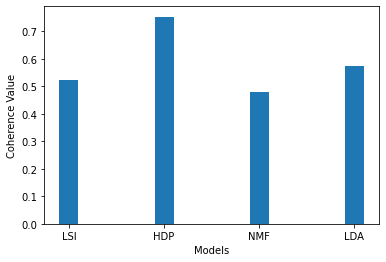

In [25]:
evaluate_bar_graph([coherence_lsi, coherence_hdp, coherence_nmf, coherence_lda],
                   ['LSI', 'HDP', 'NMF','LDA'])
print('\nLSI Coherence Score: ', coherence_lsi)
print('\nHDP Coherence Score: ', coherence_hdp)
print('\nNMF Coherence Score: ', coherence_nmf)
print('\nLDA Coherence Score: ', coherence_lda)